## KERAS for CITEseq & Multiome


<p> I'm a postgraduate student and it's my first time to join the Kaggle competition, so if my organization in this nootbook was not clear and you want to know more other information, you can comment below or send me a private message. As a result of I didn't control the time well, so the final plans were not been finished and submitted. The feature engineer's parts are not organized well so now I just to share my best NN model structure, though the final TruncaredSVD's parameters were changed a little.</p>

In [1]:
! pip install tables

In [2]:
import os, gc, pickle, datetime, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style

from sklearn.model_selection import GroupKFold,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cycler import cycler
from IPython.display import display

import scipy.sparse

DATA_DIR = "../input/open-problems-multimodal"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

VERBOSE = 0

## ------ CITEseq MODEL ---------

## Important features which are selected by myself

In [3]:
# important_cols =['ENSG00000004468',
#  'ENSG00000005961',
#  'ENSG00000010278',
#  'ENSG00000010610',
#  'ENSG00000026103',
#  'ENSG00000026508',
#  'ENSG00000072274',
#  'ENSG00000073008',
#  'ENSG00000077238',
#  'ENSG00000081237',
#  'ENSG00000083457',
#  'ENSG00000085117',
#  'ENSG00000091409',
#  'ENSG00000100031',
#  'ENSG00000101017',
#  'ENSG00000105383',
#  'ENSG00000106991',
#  'ENSG00000110651',
#  'ENSG00000110848',
#  'ENSG00000110876',
#  'ENSG00000112149',
#  'ENSG00000115232',
#  'ENSG00000117091',
#  'ENSG00000125810',
#  'ENSG00000130202',
#  'ENSG00000135218',
#  'ENSG00000135404',
#  'ENSG00000137101',
#  'ENSG00000139187',
#  'ENSG00000143226',
#  'ENSG00000150093',
#  'ENSG00000150337',
#  'ENSG00000150637',
#  'ENSG00000157873',
#  'ENSG00000160255',
#  'ENSG00000164171',
#  'ENSG00000166825',
#  'ENSG00000169442',
#  'ENSG00000173762',
#  'ENSG00000179639',
#  'ENSG00000185291',
#  'ENSG00000185896',
#  'ENSG00000186827',
#  'ENSG00000188404',
#  'ENSG00000196776',
#  'ENSG00000197635',
#  'ENSG00000198053',
#  'ENSG00000203710',
#  'ENSG00000204287',
#  'ENSG00000204592',
#  'ENSG00000206503',
#  'ENSG00000211898',
#  'ENSG00000211899',
#  'ENSG00000261371']

# print('important columns ',len(important_cols))

## Preparation of the cross validation by batch

In [4]:
metadata_df = pd.read_csv(FP_CELL_METADATA, index_col = 'cell_id')
metadata_df = metadata_df[metadata_df.technology == "citeseq"]

# Read train and convert to sparse matrix
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS)
X.columns = [t.split('_')[0] for t in X.columns]
cell_index = X.index
meta = metadata_df.reindex(cell_index)
#X0 = X[important_cols].values

del X
gc.collect()


# Read test and convert to sparse matrix
Xt = pd.read_hdf(FP_CITE_TEST_INPUTS)
Xt.columns = [t.split('_')[0] for t in Xt.columns]
cell_index_test = Xt.index
meta_test = metadata_df.reindex(cell_index_test)
#X0t = Xt[important_cols].values

del Xt
gc.collect()

#print(f'X0 shape {X0.shape} X0t shape {X0t.shape}')

58

## Target normalization

In [5]:
Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y = Y.astype('float32', copy=True)
Y.shape
gc.collect()

79

## Featrues was made by DCA(SVD), FA, scVi and Important columns which were selected by myself.

In [6]:
X = np.load("../input/citeseq-keras-1/citeseq_keras_train_data.npy")
Xt = np.load("../input/citeseq-keras-1/citeseq_keras_test_data.npy")
print(Xt.shape)

(41187, 580)


## Tensorflow Keras librairies

In [7]:
import math
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization,GaussianDropout
from tensorflow.keras.utils import plot_model

## Metric and loss function

In [8]:
def correlation_score(y_true, y_pred):
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def negative_correlation_loss(y_true, y_pred):
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, y_true.shape[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(y_true.shape[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

## Model and parameters

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          51712       input_1[0][0]                    
__________________________________________________________________________________________________
gaussian_dropout (GaussianDropo (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 380)          194940      gaussian_dropout[0][0]           
______________________________________________________________________________________________

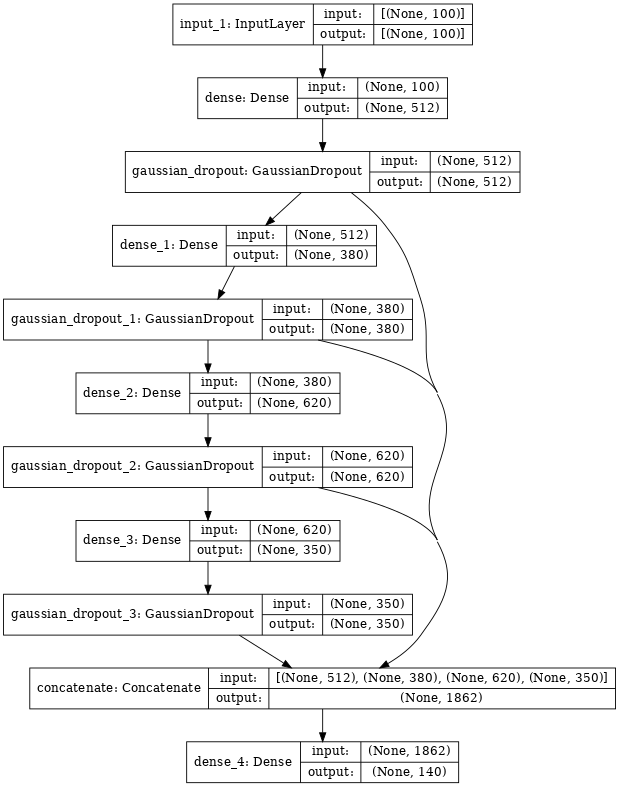

In [9]:
LR_START = 0.01
BATCH_SIZE = 512

def create_model():
    #      680, 256, 300, 140, 
    reg1 = 9.613e-06
    reg2 = 1e-07
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.15
    DROP2 = 0.05
    #512, 380, 620, 350, 0.15, 0.05
    activation = 'selu'
    inputs = Input(shape =(100,))

    x0 = Dense(512, 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = GaussianDropout(DROP)(x0)
    
    
    x1 = Dense(380, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = GaussianDropout(DROP2)(x1)
    
    
    x2 = Dense(620, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= GaussianDropout(DROP2)(x2)
    
    x3 = Dense(350,
               kernel_regularizer = REG1,
               activation = activation,
             )(x2)
    x3 = GaussianDropout(DROP2)(x3)

         
    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
    
    x = Dense(Y.shape[1], 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    
    model = Model(inputs, x)
    model.summary()

    return model
display(plot_model(create_model(), show_layer_names=True, show_shapes=True, dpi=64))

In [10]:
create_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 512)          51712       input_2[0][0]                    
__________________________________________________________________________________________________
gaussian_dropout_4 (GaussianDro (None, 512)          0           dense_5[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 380)          194940      gaussian_dropout_4[0][0]         
____________________________________________________________________________________________

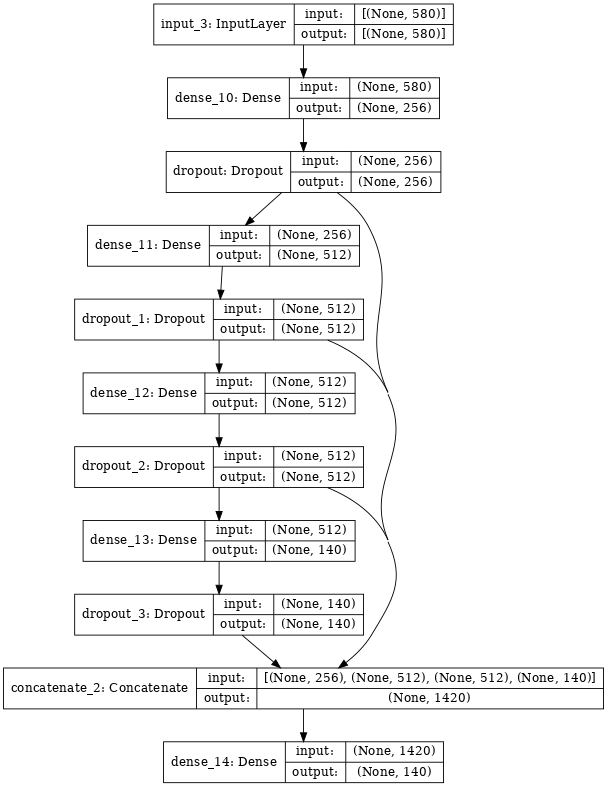

In [11]:
LR_START = 0.01
BATCH_SIZE = 512

def create_model_multi():
    reg1 = 9.613e-06
    reg2 = 1e-07
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1
    DROP2 = 0.1
    #512, 380, 620, 350, 0.15, 0.05
    activation = 'selu'
    inputs = Input(shape =(X.shape[1],))

    x0 = Dense(256, 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    
    
    x1 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = Dropout(DROP2)(x1)
    
    
    x2 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= Dropout(DROP2)(x2)
    
    x3 = Dense(140,
               kernel_regularizer = REG1,
               activation = activation,
             )(x2)
    x3 = Dropout(DROP2)(x3)

         
    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
    
    x = Dense(Y.shape[1], 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    
    model = Model(inputs, x)
    

    return model
display(plot_model(create_model_multi(), show_layer_names=True, show_shapes=True, dpi=64))

## Training

In [12]:
meta["batch"] = meta["day"].astype(str) + "_" + meta["donor"].astype(str)

In [13]:
meta.shape, X.shape,Y.shape

((70988, 5), (70988, 580), (70988, 140))

In [14]:
%%time
import warnings
warnings.filterwarnings("ignore")

EPOCHS = 600 
N_SPLITS = 9

pred_train = np.zeros((Y.shape[0],Y.shape[1]))


#kf = GroupKFold(n_splits=N_SPLITS)
kf = KFold(n_splits=N_SPLITS,shuffle=True)
score_list = []

#folds = []
# for i in [415,150,300,512,350]:
np.random.seed(1)
tf.random.set_seed(1)
for fold, (idx_tr, idx_va) in enumerate(kf.split(X)):#, groups=meta.batch
    start_time = datetime.datetime.now()
    model = None
    gc.collect()

    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]
    #c_tr =ct[idx_tr]
    #s_tr =st[idx_tr]
    X_va = X[idx_va]
    y_va = Y[idx_va]
    #c_va =ct[idx_va]
    #s_va =st[idx_va]
    print(meta["batch"][idx_va].iloc[0])
    lr = ReduceLROnPlateau(
                    monitor = "val_loss",
                    factor = 0.9, 
                    patience = 4, 
                    verbose = VERBOSE)

    es = EarlyStopping(
                    monitor = "val_loss",
                    patience = 40, 
                    verbose = VERBOSE,
                    mode = "min", 
                    restore_best_weights = True)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './citeseq',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)

    callbacks = [
                    lr, 
                    es, 
                    model_checkpoint_callback
                    ]

    model = create_model_multi()#create_model()#(True, False, False, False, False, True, True, False, False, False, False, True, True)

    model.compile(
                optimizer = tf.keras.optimizers.Adam(learning_rate=LR_START),
                metrics = [negative_correlation_loss],#None,#
                loss = negative_correlation_loss#'mse'#
                 )
    # Training
    model.fit(
                X_tr, #s_tr,
                y_tr, 
                validation_data=(
                                X_va, #s_va,
                                y_va), 
                epochs = EPOCHS,
                verbose = VERBOSE,
                batch_size = BATCH_SIZE,
                shuffle = True,
                callbacks = callbacks)

    del X_tr, y_tr 
    gc.collect()

    model.load_weights('./citeseq')
    #if meta["donor"][idx_va][0] != 13176:
    model.save(f"./submissions/model_{fold}")
        #folds.append(fold)
    print('model saved')
    #else:
    #    print('model don\'t need to be saved')

    #  Model validation
    y_va_pred = model.predict(X_va) #s_va,
    corrscore = correlation_score(y_va, y_va_pred)
    pred_train[idx_va] = y_va_pred
    #print(meta["batch"][idx_va][0])
    print(f"Fold {fold}, correlation =  {corrscore:.5f}")
    del X_va, y_va, y_va_pred
    gc.collect()
    score_list.append(corrscore)

# Show overall score
print(f"{Fore.GREEN}{Style.BRIGHT}Mean corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")
score_total = correlation_score(Y, pred_train)
print(f"{Fore.BLUE}{Style.BRIGHT}Oof corr   = {score_total:.5f}{Style.RESET_ALL}")
#Mean corr = 0.90327
#Oof corr   = 0.90242

2_32606
model saved
Fold 0, correlation =  0.90673
2_32606
model saved
Fold 1, correlation =  0.90483
2_32606
model saved
Fold 2, correlation =  0.90650
2_32606
model saved
Fold 3, correlation =  0.90609
2_32606
model saved
Fold 4, correlation =  0.90548
2_32606
model saved
Fold 5, correlation =  0.90637
2_32606
model saved
Fold 6, correlation =  0.90573
2_32606
model saved
Fold 7, correlation =  0.90508
2_32606
model saved
Fold 8, correlation =  0.90491
Mean corr = 0.90575
Oof corr   = 0.90575
CPU times: user 28min 31s, sys: 2min 9s, total: 30min 41s
Wall time: 25min 58s


## CITEseq Test prediction

In [15]:
Xt.shape

(41187, 580)

In [16]:
test_pred = np.zeros((len(Xt), 140), dtype=np.float32)
for fold in range(N_SPLITS):
    print(f"Predicting with fold {fold}")
    model = load_model(f"./submissions/model_{fold}",
                       custom_objects={'negative_correlation_loss': negative_correlation_loss})
    test_pred += model.predict(Xt)#@svd_y.components_

# Copy the targets for the data leak but useless since the change in the public LB...
#test_pred[:7476] = Y[:7476]

Predicting with fold 0
Predicting with fold 1
Predicting with fold 2
Predicting with fold 3
Predicting with fold 4
Predicting with fold 5
Predicting with fold 6
Predicting with fold 7
Predicting with fold 8


In [17]:
Xt.shape

(41187, 580)

In [18]:
test_pred.shape

(41187, 140)

## ------ Multiome MODEL ---------

## Upload of the multiome files after TruncatedSVD

In [19]:
# with open('../input/targets-multiome-sparse-scaled/INDEX_train_multiome.pkl','rb') as f: INDEX_train_multiome = pickle.load(f)
# with open('../input/targets-multiome-sparse-scaled/train_512.pkl','rb') as f: X = pickle.load(f)
# #with open('../input/targets-multiome-sparse-scaled/pca_train_512.pkl','rb') as f: pca_train = pickle.load(f)
# with open('../input/targets-multiome-sparse-scaled/pca_target_512.pkl','rb') as f: pca_target = pickle.load(f)
# with open('../input/targets-multiome-sparse-scaled/Y_512.pkl','rb') as f: Y = pickle.load(f)

In [20]:
# X = X[:,:40]
# X.shape
# # X -= X.mean(axis=0).reshape(1, -1)
# # X /= X.std(axis=0).reshape(1, -1)

In [21]:
# metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv',index_col='cell_id')
# metadata_df = metadata_df[metadata_df.technology=="multiome"]
# meta = metadata_df.reindex(INDEX_train_multiome)
# del metadata_df
# gc.collect()

In [22]:
# meta["batch"] = meta["day"].astype(str) + "_" + meta["donor"].astype(str)

In [23]:
# import scipy.sparse
# train_targets = scipy.sparse.load_npz("../input/multimodal-single-cell-as-sparse-matrix/train_multi_targets_values.sparse.npz")
# gc.collect()

## Training for Multiome

In [24]:
# %%time
# import warnings
# warnings.filterwarnings("ignore")

# N_SPLIT = 3
# kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
# #kf = GroupKFold(n_splits = N_SPLIT)
# pred_train = np.zeros((Y.shape[0],Y.shape[1]))
# for fold,(idx_tr, idx_va) in enumerate(kf.split(X)): #,groups=meta.batch
    
#     X_tr = X[idx_tr]
#     y_tr = Y[idx_tr]
    
#     X_va = X[idx_va]
#     y_va = Y[idx_va]
#     train_targets_va = train_targets[idx_va].toarray()
    
#     model = create_model_multi()
    
#     lr = ReduceLROnPlateau(
#                 monitor = "val_loss",
#                 factor = 0.9, 
#                 patience = 4, 
#                 verbose = VERBOSE)
    
#     es = EarlyStopping(
#                 monitor = "val_loss",
#                 patience = 30, 
#                 verbose = VERBOSE,
#                 mode = "min", 
#                 restore_best_weights = True)

#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#                   metrics = None,
#                   loss = 'mse')
#     model.fit(X_tr,
#               y_tr,
#               validation_data=(X_va,y_va),
#               epochs =500,
#               verbose = VERBOSE,
#               batch_size=256,
#               callbacks = [es,lr]
#              )
#     pred = model.predict(X_va)#@pca_target.components_
#     pred_train[idx_va] += pred
#     #train_targets_va
#     #corrscore = correlation_score(y_va, y_va_pred)
    
#     print(f'\n --------- FOLD {fold} -----------')
#     print(f'corrscore = {np.round(correlation_score(y_va,pred),5)}')
#     print(f'corrscore = {np.round(correlation_score(train_targets_va,pred@pca_target.components_),5)}')
   
#     filename = f"m_model_{fold}"
#     model.save(filename)
#     print('model saved :',filename)
        
#     del X_tr,X_va,y_tr,y_va
#     gc.collect()

# score_total = correlation_score(train_targets.toarray(), pred_train@pca_target.components_)
# print(f"{Fore.BLUE}{Style.BRIGHT}Oof corr   = {score_total:.5f}{Style.RESET_ALL}")

## Test predictions for Multiome

In [25]:
# multi_test_x = scipy.sparse.load_npz("../input/multimodal-single-cell-as-sparse-matrix/test_multi_inputs_values.sparse.npz")
# multi_test_x = pca_train.transform(multi_test_x)
# #multi_test_x = both[105942:]
# multi_test_x = multi_test_x[:,:40]
# multi_test_x.shape

In [26]:
# del X,Y,INDEX_train_multiome
# gc.collect()

In [27]:
# preds = np.zeros((multi_test_x.shape[0], 23418), dtype='float16')

# for fold in range(N_SPLIT):
#     print(f'fold {fold} prediction')
#     model = load_model(f"m_model_{fold}",
#                        custom_objects={'negative_correlation_loss': negative_correlation_loss})
#     preds += (model.predict(multi_test_x)@pca_target.components_)/N_SPLIT

#     gc.collect()

In [28]:
# eval_ids = pd.read_parquet("../input/multimodal-single-cell-as-sparse-matrix/evaluation.parquet")
# eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
# eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())

# submission = pd.Series(name='target',
#                        index=pd.MultiIndex.from_frame(eval_ids), 
#                        dtype=np.float32)
# submission

In [29]:
# y_columns = np.load("../input/multimodal-single-cell-as-sparse-matrix/train_multi_targets_idxcol.npz",
#                    allow_pickle=True)["columns"]

# test_index = np.load("../input/multimodal-single-cell-as-sparse-matrix/test_multi_inputs_idxcol.npz",
#                     allow_pickle=True)["index"]

# cell_dict = dict((k,v) for v,k in enumerate(test_index)) 
# assert len(cell_dict)  == len(test_index)

# gene_dict = dict((k,v) for v,k in enumerate(y_columns))
# assert len(gene_dict) == len(y_columns)

# eval_ids_cell_num = eval_ids.cell_id.apply(lambda x:cell_dict.get(x, -1))
# eval_ids_gene_num = eval_ids.gene_id.apply(lambda x:gene_dict.get(x, -1))
# valid_multi_rows = (eval_ids_gene_num !=-1) & (eval_ids_cell_num!=-1)

# submission.iloc[valid_multi_rows] = preds[eval_ids_cell_num[valid_multi_rows].to_numpy(),
# eval_ids_gene_num[valid_multi_rows].to_numpy()]

# del eval_ids_cell_num, eval_ids_gene_num, valid_multi_rows, eval_ids, test_index, y_columns
# gc.collect()

# submission

## Total submission

In [30]:
submission1 = pd.read_csv("/kaggle/input/2nd-place-gru-cite/submission.csv")

In [31]:
test_pred.ravel().shape

(5766180,)

In [32]:
7476*140 + 5766180

6812820

In [33]:
submission1["target"].iloc[7476*140:6812820] = test_pred.ravel()

In [34]:
submission1["target"]

0          -0.569636
1          -0.524233
2          -0.352286
3           1.292455
4           1.361938
              ...   
65744175    4.410036
65744176   -0.576845
65744177   -0.593088
65744178    0.251146
65744179    3.899600
Name: target, Length: 65744180, dtype: float64

In [35]:
# submission.reset_index(drop=True, inplace=True)
# submission.index.name = 'row_id'

# cite_submission = pd.read_csv("submission_lolo_1.csv")
# cite_submission = cite_submission.set_index("row_id")
# cite_submission = cite_submission["target"]
# submission[submission.isnull()] = cite_submission[submission.isnull()]
# submission

In [36]:
# del cite_submission
# gc.collect()

In [37]:
# sub_ensembling = pd.read_csv('../input/open-problems-multimodal/sample_submission.csv')
# submission1 = sub_ensembling.copy()
# submission1['target'] = submission
# submission1

In [38]:
submission1.to_csv("submission.csv", index = False)

In [39]:
# %%time
# sub_preds = test_pred.reshape(-1)
# multi_preds = np.load('/kaggle/input/single-cell-features/senkin_multi_predictions.npy')

# sub = pd.read_csv('../input/open-problems-multimodal/sample_submission.csv')
# sub['target'] = np.concatenate([sub_preds,multi_preds])
# sub.to_csv('submission.csv',index=False)

In [40]:
# sub_preds.shape[0] + multi_preds.shape[0]

In [41]:
# multi_preds.shape